In [2]:
# import libraries
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from network import Network
from utils import device, get_all_preds, get_num_correct

In [3]:
# covertes to tensor and normalizes the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_set = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform
)
test_set = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform
)
# load the train set and test set
train_loader = torch.utils.data.DataLoader(train_set, batch_size=500, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


## when data augmentation wasn't used during training
Note: in this case we randomly sampled 20% of the train set to be used for validation set

In [4]:
# load the model with least validation loss
model = Network().to(device)
model.load_state_dict(
    torch.load('models/model-run(lr=0.003, batch_size=128).ckpt',
    map_location=device)
)

<All keys matched successfully>

In [5]:
model

Network(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(i

In [6]:
# set model to eval mode as we won't be needing any training now and turn off gradient tracking as well
model.eval()
with torch.no_grad(): 
    test_preds = get_all_preds(model, test_loader)
    print(test_preds.shape)  # shape of the predicted test scores

torch.Size([10000, 10])


In [7]:
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets))
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Test Correct:   7668	Test Accuracy:  76.68%


In [8]:
test_stacked = torch.stack(
    (torch.as_tensor(test_set.targets), test_preds.argmax(dim=1)),
    dim=1
)  # shape [10000, 2]

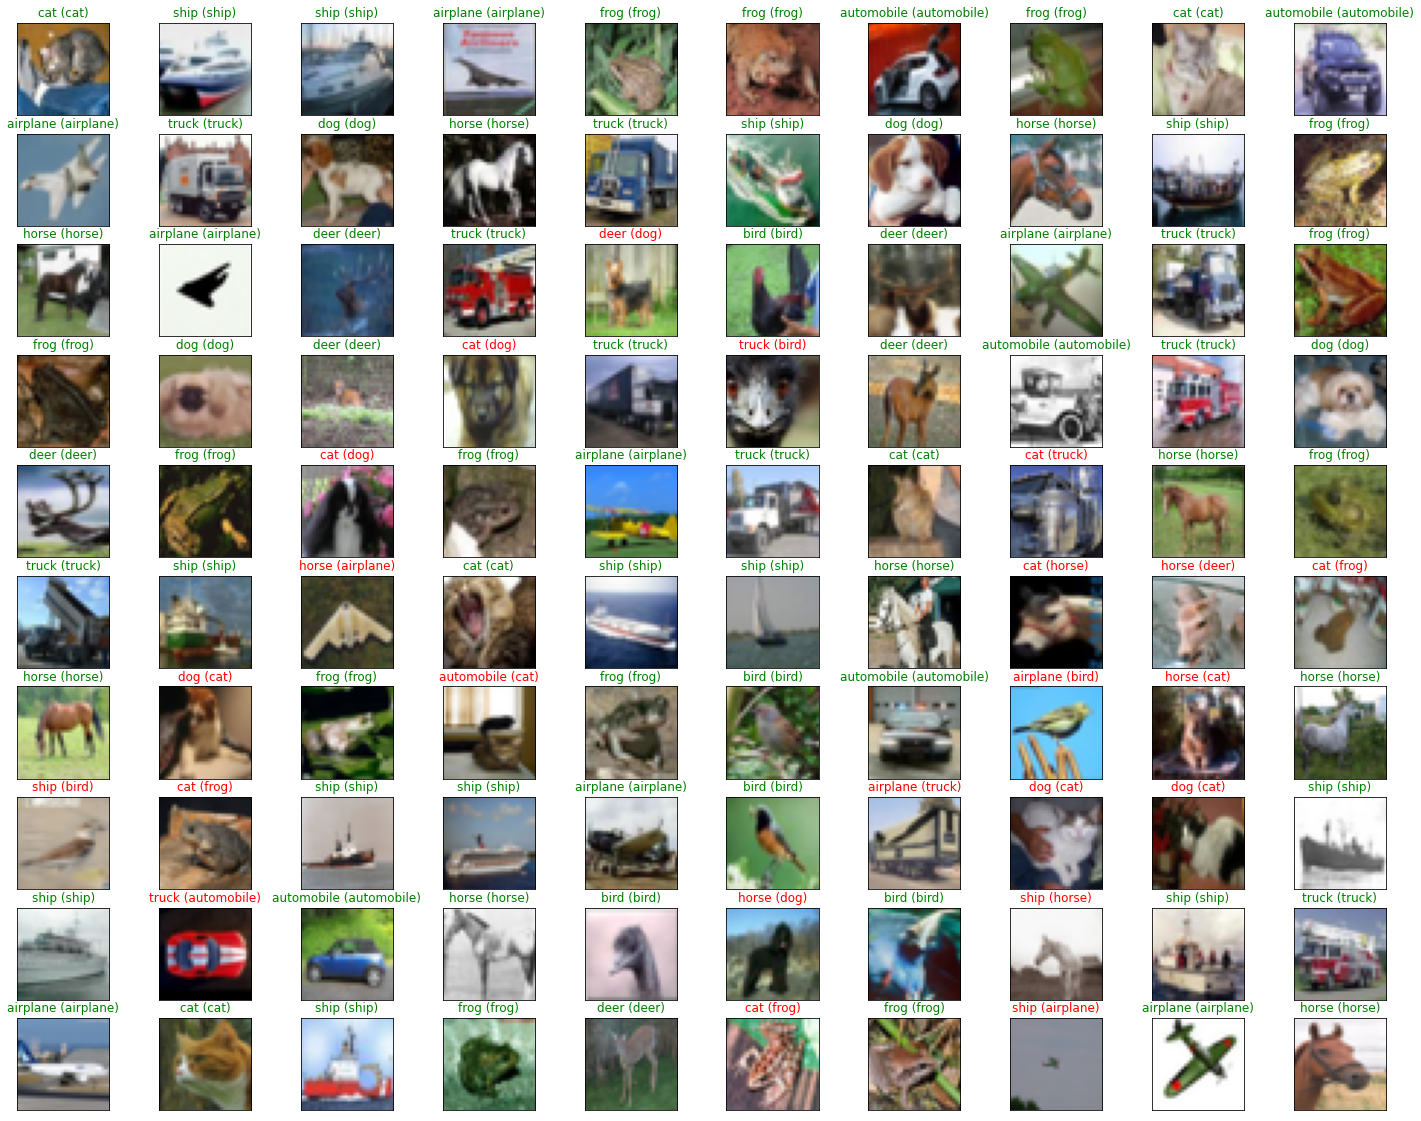

In [9]:
# obtain one batch of test images
images, labels = next(iter(test_loader))
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
# plot format: "predicted-label (true-label)"
fig = plt.figure(figsize=(25, 20))
for i in np.arange(100):
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    img = np.squeeze(np.transpose(images[i], (1,2,0)))  # B*C*H*W --> H*W*C
    img = img/2 + 0.5  # un-normalize the image
    ax.imshow(img)
    ax.set_title(f'{test_set.classes[test_stacked[i, 1].item()]} ({test_set.classes[labels[i].item()]})',
                color=('green' if test_stacked[i, 1]==labels[i] else 'red'))

plt.show()
fig.savefig('visualizations/test_results.png', bbox_inches='tight')
plt.close()

In [10]:
# calculate the confusion matrix for the test_set using test_stacked we calculated above
test_confmat = torch.zeros(10, 10, dtype=torch.int16)
for row in test_stacked:
    cl, pl = row.tolist()
    test_confmat[cl, pl] += 1

test_confmat

tensor([[858,  15,  21,  15,  17,   5,   8,   7,  37,  17],
        [ 16, 863,   6,   9,   3,   2,   4,   3,  27,  67],
        [ 68,   3, 625,  49,  96,  66,  50,  29,   9,   5],
        [ 26,  12,  48, 587,  66, 160,  39,  37,  13,  12],
        [ 22,   2,  35,  58, 794,  23,  21,  40,   2,   3],
        [ 11,   7,  32, 183,  44, 645,  13,  55,   7,   3],
        [  7,   3,  26,  76,  39,  23, 811,   6,   7,   2],
        [ 10,   1,  19,  42,  62,  48,   4, 800,   4,  10],
        [ 64,  19,   5,   8,  12,   2,   1,   8, 869,  12],
        [ 45,  64,   6,  21,   6,   2,   6,  12,  22, 816]], dtype=torch.int16)

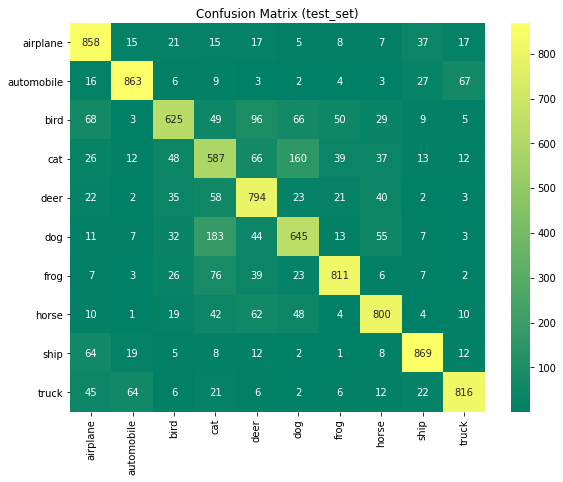

In [11]:
# plot confusion matrix
cm_test = pd.DataFrame(test_confmat.numpy(), index=test_set.classes, columns=test_set.classes)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
ax = sns.heatmap(cm_test, annot=True, cmap='summer', fmt='d', annot_kws={'size': 10})
ax.set_title("Confusion Matrix (test_set)")

plt.show()
fig.savefig('visualizations/confusion_matrix_without_aug.png', bbox='tight')
plt.close()

In [12]:
# print per-class test accuracy
for i in range(10):
    print('Test accuracy of {:12s}:\t{:.2f}% ({}/{})'.format(
        test_set.classes[i],
        100 * (test_confmat[i,i]/torch.as_tensor(test_set.targets).bincount()[i].item()),
        test_confmat[i,i],
        torch.as_tensor(test_set.targets).bincount()[i].item()
    ))

Test accuracy of airplane    :	85.80% (858/1000)
Test accuracy of automobile  :	86.30% (863/1000)
Test accuracy of bird        :	62.50% (625/1000)
Test accuracy of cat         :	58.70% (587/1000)
Test accuracy of deer        :	79.40% (794/1000)
Test accuracy of dog         :	64.50% (645/1000)
Test accuracy of frog        :	81.10% (811/1000)
Test accuracy of horse       :	80.00% (800/1000)
Test accuracy of ship        :	86.90% (869/1000)
Test accuracy of truck       :	81.60% (816/1000)


## when data augmentation was used during training
Note: in this case we randomly sampled 50% of the test set to be used for validation set

In [13]:
# load the model with least validation loss
model = Network().to(device)
model.load_state_dict(
    torch.load('models/with_aug/model-run(lr=0.001, batch_size=128).ckpt',
    map_location=device)
)

<All keys matched successfully>

In [14]:
# set model to eval mode as we won't be needing any training now and turn off gradient tracking as well
model.eval()
with torch.no_grad():
    train_preds = get_all_preds(model, train_loader)
    test_preds = get_all_preds(model, test_loader)
    print(train_preds.shape)  # shape of the predicted train scores
    print(test_preds.shape)  # shape of the predicted test scores

torch.Size([50000, 10])
torch.Size([10000, 10])


In [15]:
train_correct = get_num_correct(train_preds, torch.as_tensor(train_set.targets))
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets))

print(f'Train Correct: {train_correct:5}\tTrain Accuracy: {(100*train_correct/len(train_set)):5.2f}%')
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Train Correct: 42573	Train Accuracy: 85.15%
Test Correct:   7976	Test Accuracy:  79.76%


In [16]:
# stack the correct label and the predicted label side by side
train_stacked = torch.stack(
    (torch.as_tensor(train_set.targets), train_preds.argmax(dim=1)),
    dim=1
)  # shape [50000, 2]
test_stacked = torch.stack(
    (torch.as_tensor(test_set.targets), test_preds.argmax(dim=1)),
    dim=1
)  # shape [10000, 2]

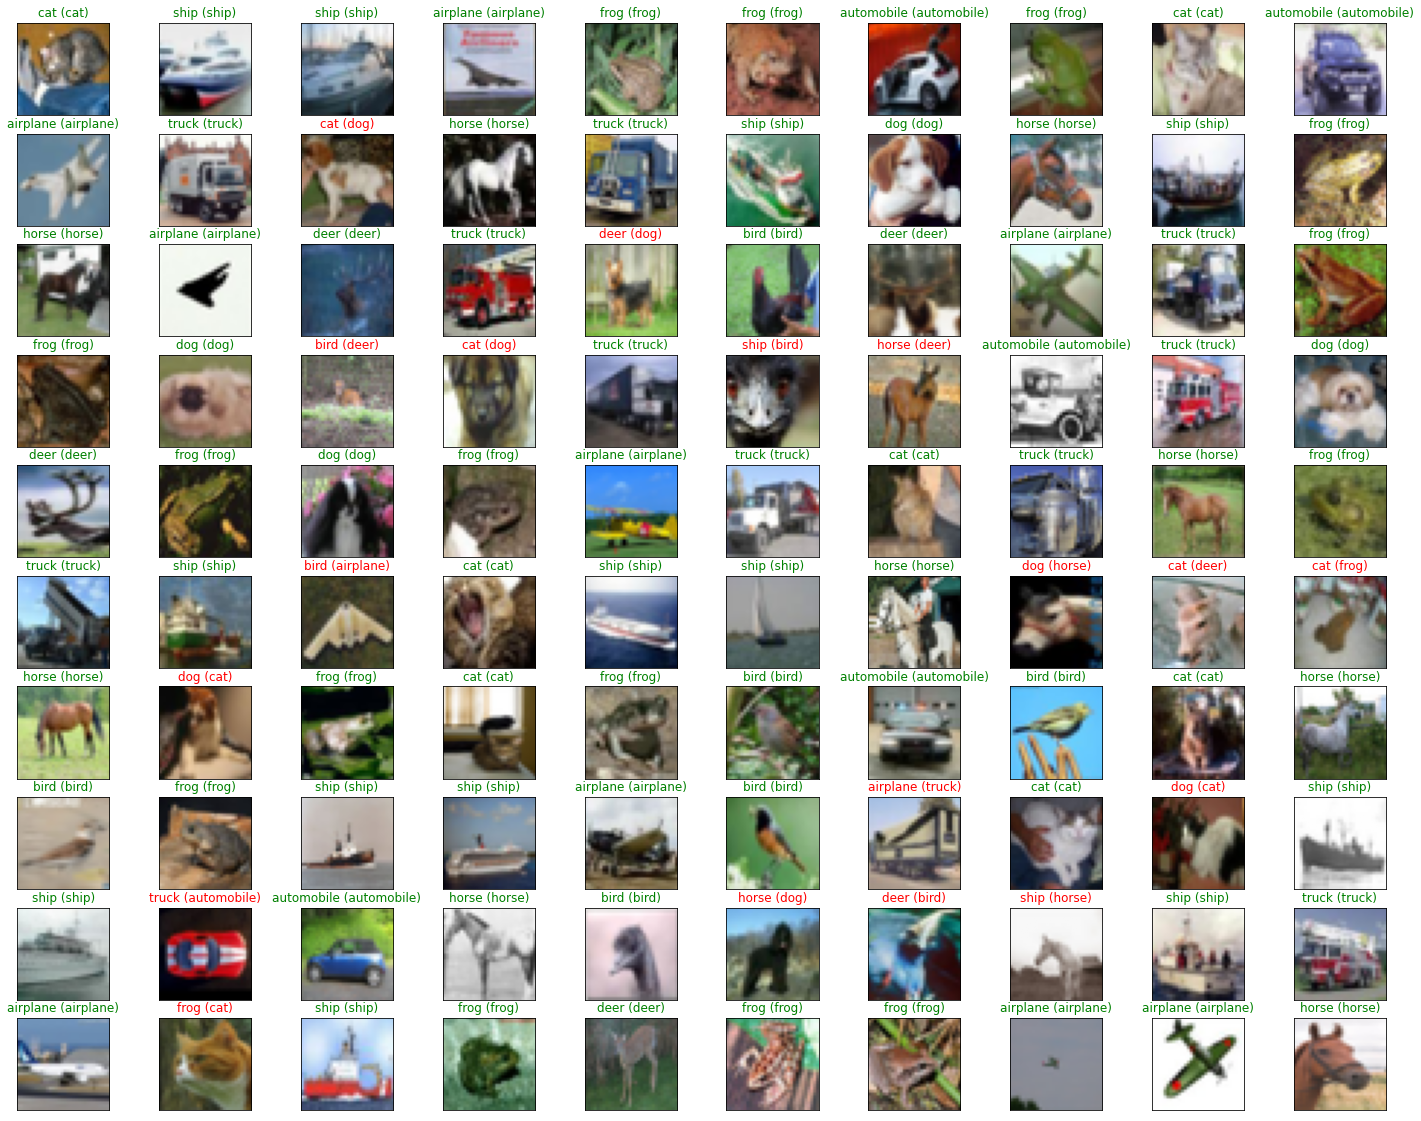

In [17]:
# obtain one batch of test images
images, labels = next(iter(test_loader))
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
# plot format: "predicted-label (true-label)"
fig = plt.figure(figsize=(25, 20))
for i in np.arange(100):
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    img = np.squeeze(np.transpose(images[i], (1,2,0)))  # B*C*H*W --> H*W*C
    img = img/2 + 0.5  # un-normalize the image
    ax.imshow(img)
    ax.set_title(f'{test_set.classes[test_stacked[i, 1].item()]} ({test_set.classes[labels[i].item()]})',
                color=('green' if test_stacked[i, 1]==labels[i] else 'red'))

plt.show()
fig.savefig('visualizations/test_results_with_aug.png', bbox_inches='tight')
plt.close()

In [18]:
# calculate the confusion matrix for the test_set using test_stacked we calculated above
train_confmat = torch.zeros(10, 10, dtype=torch.int16)
for row in train_stacked:
    cl, pl = row.tolist()
    train_confmat[cl, pl] += 1

train_confmat

tensor([[4501,   34,  133,   37,   22,   22,   20,   19,  131,   81],
        [  49, 4677,   12,   10,    3,    3,   10,    2,   51,  183],
        [ 214,   11, 3875,  177,  185,  167,  245,   74,   30,   22],
        [  98,   15,  210, 3356,  165,  651,  334,   98,   35,   38],
        [ 119,    3,  175,  148, 4090,  107,  164,  159,   15,   20],
        [  29,    6,  138,  611,  120, 3785,  131,  148,   10,   22],
        [  23,   16,   94,  100,   53,   38, 4646,    4,   16,   10],
        [  36,    6,   83,  147,  105,  146,   21, 4424,    6,   26],
        [ 165,   66,   27,   17,    9,    5,   11,    3, 4633,   64],
        [  99,  174,   16,   21,    5,   16,   18,   13,   52, 4586]],
       dtype=torch.int16)

In [19]:
# calculate the confusion matrix for the test_set using test_stacked we calculated above
test_confmat = torch.zeros(10, 10, dtype=torch.int16)
for row in test_stacked:
    cl, pl = row.tolist()
    test_confmat[cl, pl] += 1

test_confmat

tensor([[849,  12,  42,  11,   5,   5,  10,   7,  33,  26],
        [ 13, 909,   0,   3,   0,   1,   4,   3,  14,  53],
        [ 61,   3, 698,  43,  54,  46,  59,  19,   5,  12],
        [ 29,   4,  52, 585,  44, 146,  89,  26,  11,  14],
        [ 28,   1,  45,  46, 746,  24,  45,  56,   7,   2],
        [ 16,   0,  29, 137,  32, 701,  43,  37,   1,   4],
        [ 11,   2,  22,  22,  20,  13, 896,   4,   6,   4],
        [ 14,   4,  21,  34,  30,  48,   4, 836,   1,   8],
        [ 52,  17,   4,   7,   4,   2,   7,   4, 881,  22],
        [ 30,  48,   7,   7,   0,   5,   6,   5,  17, 875]], dtype=torch.int16)

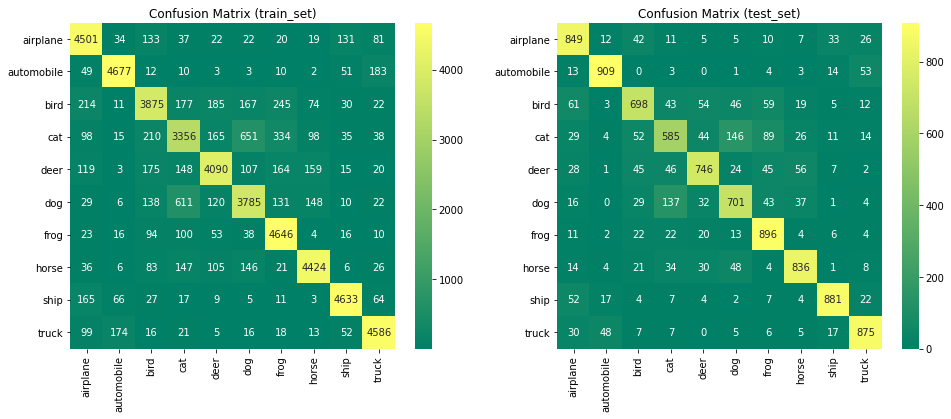

In [22]:
# plot confusion matrices
cm_train = pd.DataFrame(train_confmat.numpy(), index=train_set.classes, columns=train_set.classes)
cm_test = pd.DataFrame(test_confmat.numpy(), index=test_set.classes, columns=test_set.classes)

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax = sns.heatmap(cm_train, annot=True, cmap='summer', fmt='d', annot_kws={'size': 10})
ax.set_title("Confusion Matrix (train_set)")
ax = fig.add_subplot(122)
ax = sns.heatmap(cm_test, annot=True, cmap='summer', fmt='d', annot_kws={'size': 10})
ax.set_title("Confusion Matrix (test_set)")

plt.show()
fig.savefig('visualizations/confusion_matrix_with_aug.png', bbox='tight')
plt.close()

In [23]:
# print per-class train accuracy
for i in range(10):
    print('Train accuracy of {:12s}:\t{:.2f}% ({}/{})'.format(
        train_set.classes[i],
        100 * (train_confmat[i,i]/torch.as_tensor(train_set.targets).bincount()[i].item()),
        train_confmat[i,i],
        torch.as_tensor(train_set.targets).bincount()[i].item()
    ))

Train accuracy of airplane    :	90.02% (4501/5000)
Train accuracy of automobile  :	93.54% (4677/5000)
Train accuracy of bird        :	77.50% (3875/5000)
Train accuracy of cat         :	67.12% (3356/5000)
Train accuracy of deer        :	81.80% (4090/5000)
Train accuracy of dog         :	75.70% (3785/5000)
Train accuracy of frog        :	92.92% (4646/5000)
Train accuracy of horse       :	88.48% (4424/5000)
Train accuracy of ship        :	92.66% (4633/5000)
Train accuracy of truck       :	91.72% (4586/5000)


In [24]:
# print per-class test accuracy
for i in range(10):
    print('Test accuracy of {:12s}:\t{:.2f}% ({}/{})'.format(
        test_set.classes[i],
        100 * (test_confmat[i,i]/torch.as_tensor(test_set.targets).bincount()[i].item()),
        test_confmat[i,i],
        torch.as_tensor(test_set.targets).bincount()[i].item()
    ))

Test accuracy of airplane    :	84.90% (849/1000)
Test accuracy of automobile  :	90.90% (909/1000)
Test accuracy of bird        :	69.80% (698/1000)
Test accuracy of cat         :	58.50% (585/1000)
Test accuracy of deer        :	74.60% (746/1000)
Test accuracy of dog         :	70.10% (701/1000)
Test accuracy of frog        :	89.60% (896/1000)
Test accuracy of horse       :	83.60% (836/1000)
Test accuracy of ship        :	88.10% (881/1000)
Test accuracy of truck       :	87.50% (875/1000)
